In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('housing.csv')
len(df)

20640

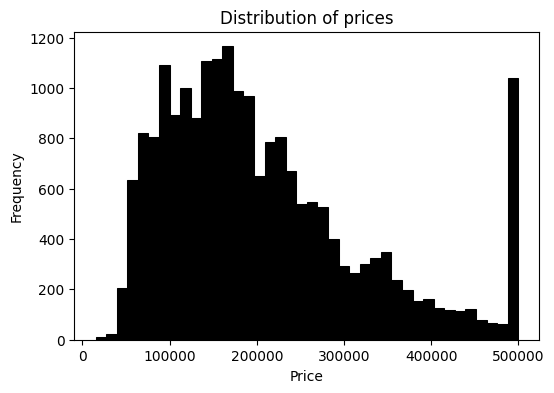

In [3]:
plt.figure(figsize=(6, 4))

#sns.histplot(df.msrp[df.msrp < 100000], bins=40, color='black', alpha=1)
sns.histplot(df.median_house_value, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

In [4]:
df = df[df.ocean_proximity.isin(['<1H OCEAN', 'INLAND'])]
df = df[['latitude',
        'longitude',
        'housing_median_age',
        'total_rooms',
        'total_bedrooms',
        'population',
        'households',
        'median_income',
        'median_house_value']]
df.shape

(15687, 9)

In [5]:
missing_cols = df.columns[df.isnull().any()].tolist()
print(missing_cols)

['total_bedrooms']


In [6]:
df.population.median()

1195.0

In [7]:
df.describe().to_json()

'{"latitude":{"count":15687.0,"mean":35.4673066871,"std":2.0663867734,"min":32.61,"25%":33.94,"50%":34.16,"75%":37.34,"max":41.95},"longitude":{"count":15687.0,"mean":-119.2174418308,"std":1.7803801496,"min":-124.14,"25%":-121.07,"50%":-118.37,"75%":-117.99,"max":-114.31},"housing_median_age":{"count":15687.0,"mean":27.1881175496,"std":12.0571280972,"min":1.0,"25%":17.0,"50%":27.0,"75%":36.0,"max":52.0},"total_rooms":{"count":15687.0,"mean":2665.6773124243,"std":2257.6727428043,"min":2.0,"25%":1441.0,"50%":2118.0,"75%":3172.0,"max":39320.0},"total_bedrooms":{"count":15530.0,"mean":541.2446877012,"std":435.6500176406,"min":2.0,"25%":295.0,"50%":432.0,"75%":645.0,"max":6445.0},"population":{"count":15687.0,"mean":1466.3172053293,"std":1180.3899082759,"min":3.0,"25%":802.0,"50%":1195.0,"75%":1777.0,"max":35682.0},"households":{"count":15687.0,"mean":500.9164913623,"std":392.7593992797,"min":2.0,"25%":278.0,"50%":406.0,"75%":602.0,"max":6082.0},"median_income":{"count":15687.0,"mean":3.804

In [8]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
df = df.sample(frac=1, random_state=42)

# Splitting the data into train/val/test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Applying the log transformation to the 'median_house_value' variable
train['median_house_value'] = np.log1p(train['median_house_value'])
val['median_house_value'] = np.log1p(val['median_house_value'])
test['median_house_value'] = np.log1p(test['median_house_value'])

# Print the proportions of the 3 datasets to the original df
print(f"Proportion of train set: {len(train)/len(df)}")
print(f"Proportion of validation set: {len(val)/len(df)}")
print(f"Proportion of test set: {len(test)/len(df)}")

Proportion of train set: 0.5999235035379614
Proportion of validation set: 0.20003824823101932
Proportion of test set: 0.20003824823101932


In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Function to train a linear regression model
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# Preparing the target variable
y_train = train['median_house_value'].values
y_val = val['median_house_value'].values

# Preparing the features
X_train_0 = train.fillna(0).drop('median_house_value', axis=1).values
X_val_0 = val.fillna(0).drop('median_house_value', axis=1).values

X_train_mean = train.fillna(train.mean()).drop('median_house_value', axis=1).values
X_val_mean = val.fillna(train.mean()).drop('median_house_value', axis=1).values

# Training the models and making predictions
w0_0, w_0 = train_linear_regression(X_train_0, y_train)
y_pred_0 = w0_0 + X_val_0.dot(w_0)

w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)

# Calculating the RMSE scores
score_0 = np.sqrt(mean_squared_error(y_val, y_pred_0))
score_mean = np.sqrt(mean_squared_error(y_val, y_pred_mean))

# Printing the RMSE scores
print("RMSE score when missing values are filled with 0: ", round(score_0, 2))
print("RMSE score when missing values are filled with mean: ", round(score_mean, 2))


RMSE score when missing values are filled with 0:  0.33
RMSE score when missing values are filled with mean:  0.33


In [10]:
train.mean()

latitude                35.486446
longitude             -119.226382
housing_median_age      27.060461
total_rooms           2656.624163
total_bedrooms         537.820590
population            1454.077356
households             497.872915
median_income            3.807727
median_house_value      12.007972
dtype: float64

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Function to train a regularized linear regression model
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# Preparing the target variable
y_train = train['median_house_value'].values
y_val = val['median_house_value'].values

# Preparing the features
X_train_0 = train.fillna(0).drop('median_house_value', axis=1).values
X_val_0 = val.fillna(0).drop('median_house_value', axis=1).values

# List of regularization coefficients to try
r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

# Training the models and calculating the RMSE scores for each r value
for r in r_values:
    w0, w = train_linear_regression_reg(X_train_0, y_train, r=r)
    y_pred = w0 + X_val_0.dot(w)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"RMSE score for r={r}: ", round(score, 2))

RMSE score for r=0:  0.33
RMSE score for r=1e-06:  0.33
RMSE score for r=0.0001:  0.33
RMSE score for r=0.001:  0.33
RMSE score for r=0.01:  0.33
RMSE score for r=0.1:  0.33
RMSE score for r=1:  0.34
RMSE score for r=5:  0.34
RMSE score for r=10:  0.34


In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Function to train a linear regression model
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# List of seed values to try
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# List to store the RMSE scores for each seed value
scores = []
df_copy = df.copy()
# For each seed value
for seed in seed_values:
    # Set the seed for NumPy's random number generator
    np.random.seed(seed)

    # Shuffle and split the data into train/val/test sets
    df = df_copy
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]
    
    train = df_shuffled.iloc[:n_train].copy()
    val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    test = df_shuffled.iloc[n_train+n_val:].copy()

    # Preparing the target variable and features
    y_train = train['median_house_value'].values
    y_val = val['median_house_value'].values

    X_train_0 = train.fillna(0).drop('median_house_value', axis=1).values
    X_val_0 = val.fillna(0).drop('median_house_value', axis=1).values

    # Training the model and making predictions
    w0_0, w_0 = train_linear_regression(X_train_0, y_train)
    y_pred_0 = w0_0 + X_val_0.dot(w_0)

    # Calculating the RMSE score and adding it to the list of scores
    score_0 = np.sqrt(mean_squared_error(y_val, y_pred_0))
    scores.append(score_0)

# Computing the standard deviation of all the RMSE scores
std_dev = np.std(scores)

# Printing the standard deviation of the RMSE scores
print("Standard deviation of RMSE scores: ", round(std_dev, 3))

Standard deviation of RMSE scores:  1280.366


In [8]:
scores

[63851.52541934526,
 64738.72766232962,
 65924.48892010374,
 65363.63200891588,
 66262.68573840072,
 67855.26402647048,
 65481.773267139935,
 67366.2565607358,
 67803.46231414078,
 65058.79576640671]

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Function to train a regularized linear regression model
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# Set the seed for NumPy's random number generator
np.random.seed(9)

# Shuffle and split the data into train/val/test sets
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

train = df_shuffled.iloc[:n_train].copy()
val = df_shuffled.iloc[n_train:n_train+n_val].copy()
test = df_shuffled.iloc[n_train+n_val:].copy()

# Combine the train and validation datasets
train = pd.concat([train, val])

# Preparing the target variable and features
y_train = train['median_house_value'].values
y_test = test['median_house_value'].values

X_train_0 = train.fillna(0).drop('median_house_value', axis=1).values
X_test_0 = test.fillna(0).drop('median_house_value', axis=1).values

# Training the model and making predictions
w0_0, w_0 = train_linear_regression_reg(X_train_0, y_train, r=0.001)
y_pred_0 = w0_0 + X_test_0.dot(w_0)

# Calculating the RMSE score
score_0 = np.sqrt(mean_squared_error(y_test, y_pred_0))

# Printing the RMSE score
print("RMSE score on test dataset: ", round(score_0, 3))

RMSE score on test dataset:  66713.687
